<a href="https://colab.research.google.com/github/HowonRyu/ConfidenceSet/blob/main/example/Independent_Studies_2023Winter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import random
import sys
import os
import math
import scipy.stats
from tabulate import tabulate

#!rm -rf ConfSets
#!git clone https://github.com/TomMaullin/ConfSets.git
#sys.path.append('/content/ConfSets/lib/')
#from generateData import *
#from boundary import *

!pip install git+https://github.com/HowonRyu/ConfidenceSet.git
from confidenceset.functions import *

%load_ext autoreload
%autoreload 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/HowonRyu/ConfidenceSet.git to /tmp/pip-req-build-49c6jwp5
  Running command git clone --filter=blob:none --quiet https://github.com/HowonRyu/ConfidenceSet.git /tmp/pip-req-build-49c6jwp5
  Resolved https://github.com/HowonRyu/ConfidenceSet.git to commit 46543ca5499de0a96e3a5d5cbebde492b51967f1
  Preparing metadata (setup.py) ... done
  Created wheel for confidenceset: filename=confidenceset-0.0.2-py3-none-any.whl size=9739 sha256=b76ab36a3540c6786f9031f61a02629ced1d221ccdf384882aea4d49cce4dab2
  Stored in directory: /tmp/pip-ephem-wheel-cache-873eni1g/wheels/ca/53/0c/d685b1f54ab8d50428630ab153815b0ac1c2f385a4ebecb60e
Successfully built confidenceset


# FDR Confidence Set



\begin{array}{|c|c|} \hline
 & N & P &  \\ \hline
H_0 & TN & FP & m_0 \\
H_1 & FN & TP & m-m_0 \\ \hline
 & m-R & R & m \\ \hline
\end{array}


**Family Wise Error Rate (FWER)**
*   $FWER = P(FP \ge 1 | H_0)$
*   In multiple testing, use Bonferroni to control for: $FWER <\frac{\alpha}{m}$



**False Discovery Rate (FDR)**

*   $FDR = E(\frac{FP}{R} | R>0)P(R>0) = E \frac{FP}{\max(1,R)} $
*  ((If you can add BH proof))

## Signals

Different settings of image size and variance

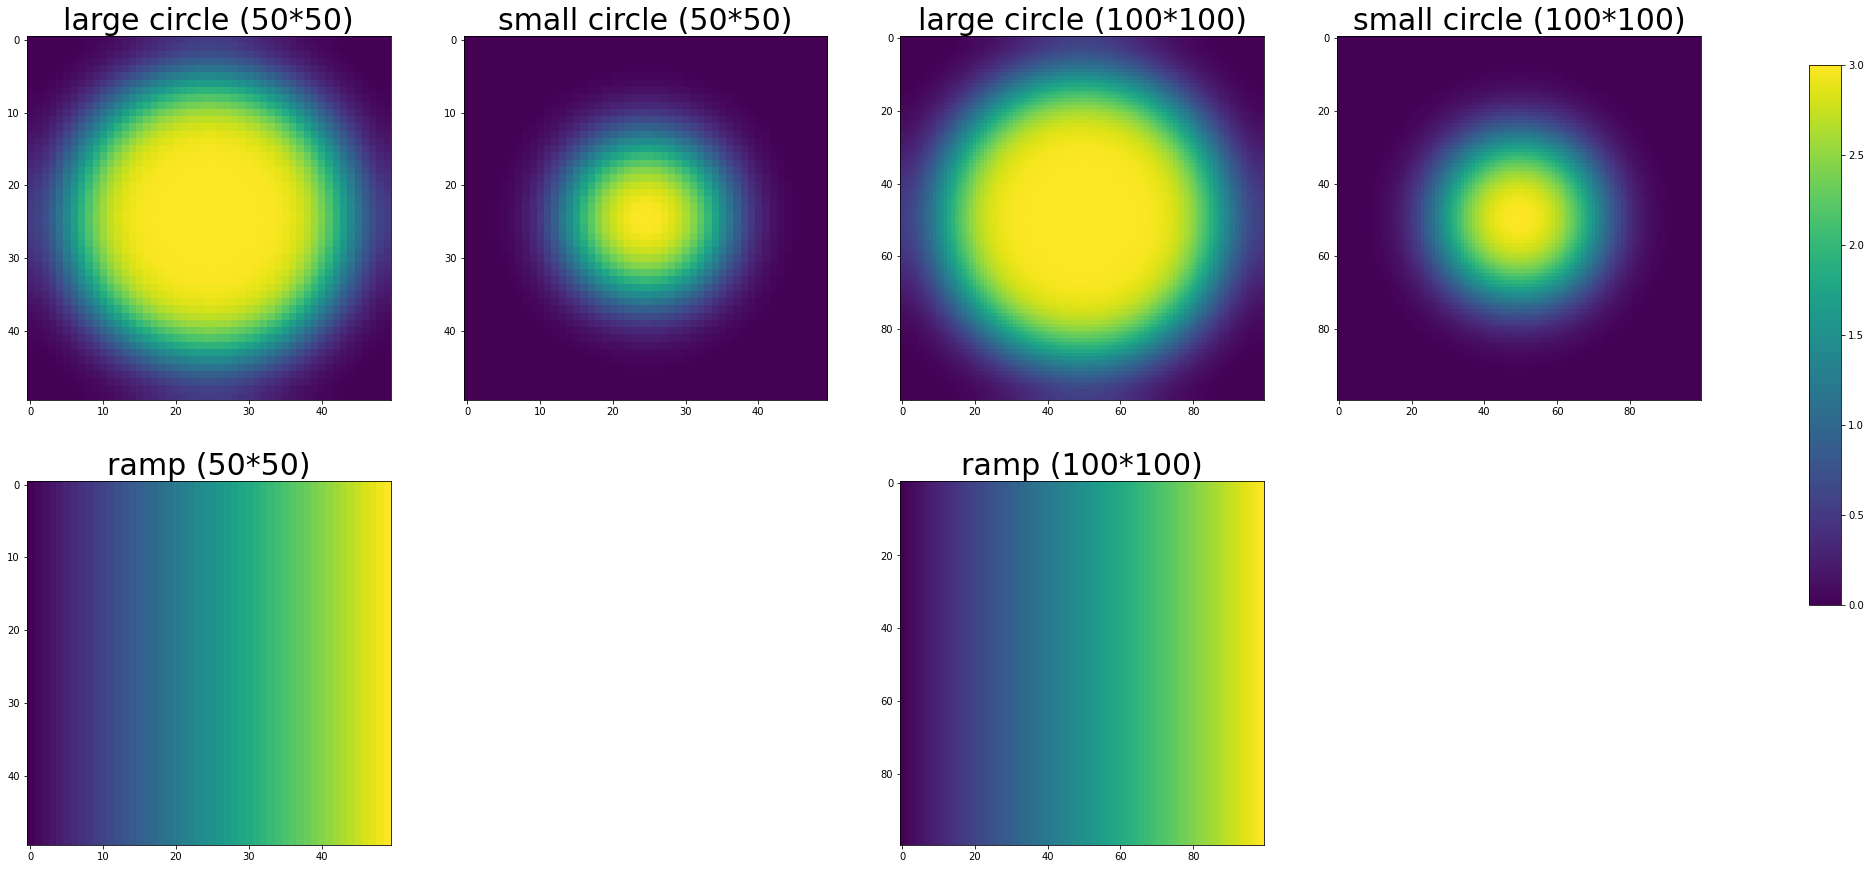

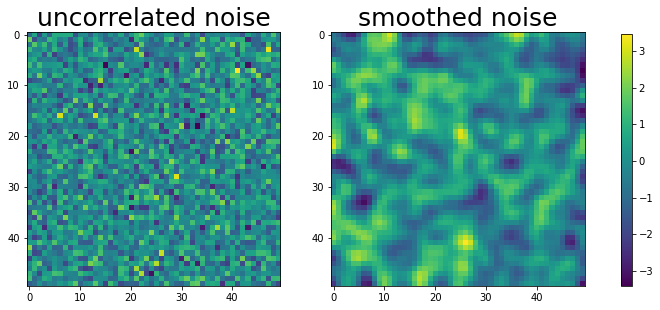

In [2]:
dim_100 = (80,100,100)
dim_50 = (80, 50, 50)
std = 5
mag = 3

spec_cir_l50 = {'r':0.8, 'std':std, 'mag':mag, 'fwhm_noise':0, 'fwhm_signal':10 }
spec_cir_s50 = {'r':0.45, 'std':std, 'mag':mag, 'fwhm_noise':0, 'fwhm_signal':10 }
spec_cir_l100 = {'r':0.8, 'std':std,'mag':mag, 'fwhm_noise':0, 'fwhm_signal':10*2 }
spec_cir_s100 = {'r':0.45, 'std':std,'mag':mag, 'fwhm_noise':0, 'fwhm_signal':10*2 }
spec_cir_l50_smth = {'r':0.8, 'std':std,'mag':mag, 'fwhm_noise':3, 'fwhm_signal':10 }
spec_cir_s50_smth = {'r':0.45, 'std':std,'mag':mag, 'fwhm_noise':3, 'fwhm_signal':10 }
spec_cir_l100_smth = {'r':0.8, 'std':std,'mag':mag, 'fwhm_noise':3*2, 'fwhm_signal':10*2 }
spec_cir_s100_smth = {'r':0.45, 'std':std,'mag':mag, 'fwhm_noise':3*2, 'fwhm_signal':10*2 }

#circular
circular_l, mu_circular_l = circular_2D(dim=dim_50, shape_spec=spec_cir_l50)
circular_s, mu_circular_s = circular_2D(dim=dim_50, shape_spec=spec_cir_s50)
circular_l100, mu_circular_l100 = circular_2D(dim=dim_100, shape_spec=spec_cir_l100)
circular_s100, mu_circular_s100 = circular_2D(dim=dim_100, shape_spec=spec_cir_s100)
circular_l_smth, mu_circular_l_smth = circular_2D(dim=dim_50, shape_spec=spec_cir_l50_smth)
circular_s_smth, mu_circular_s_smth = circular_2D(dim=dim_50, shape_spec=spec_cir_s50_smth)
circular_l100_smth, mu_circular_l100_smth = circular_2D(dim=dim_100, shape_spec=spec_cir_l100_smth)
circular_s100_smth, mu_circular_s100_smth = circular_2D(dim=dim_100, shape_spec=spec_cir_s100_smth)

#ramp
ramp_50, mu_ramp_50 = ramp_2D(dim=dim_50, mag=(0,mag), direction=1, fwhm=0, std=std)
ramp_50_smth, mu_ramp_50_smth = ramp_2D(dim=dim_50, mag=(0,mag), direction=1, fwhm=3, std=std)
ramp_100, mu_ramp_100 = ramp_2D(dim=dim_100, mag=(0,mag), direction=1, fwhm=0, std=5)
ramp_100_smth, mu_ramp_100_smth = ramp_2D(dim=dim_100, mag=(0,mag), direction=1, fwhm=3*2, std=std)


#plotting
fig, axs = plt.subplots(2, 4, figsize=(30, 15))
im = axs[0,0].imshow(mu_circular_l)
axs[0,0].set_title("large circle (50*50)", fontsize = 30)
#plt.colorbar(im00, ax=axs[0, 0])

im = axs[0,1].imshow(mu_circular_s)
axs[0,1].set_title("small circle (50*50)", fontsize = 30)
#plt.colorbar(im01, ax=axs[0, 1])

im = axs[0,2].imshow(mu_circular_l100)
axs[0,2].set_title("large circle (100*100)", fontsize = 30)
#plt.colorbar(im02, ax=axs[0, 2])

im = axs[0,3].imshow(mu_circular_s100)
axs[0,3].set_title("small circle (100*100)", fontsize = 30)
#plt.colorbar(im03, ax=axs[0, 3])

im = axs[1,0].imshow(mu_ramp_50)
axs[1,0].set_title("ramp (50*50)", fontsize = 30)
#plt.colorbar(im00, ax=axs[0, 0])

im = axs[1,2].imshow(mu_ramp_100)
axs[1,2].set_title("ramp (100*100)", fontsize = 30)
#plt.colorbar(im01, ax=axs[0, 1])

axs[1, 1].text(0.5, 0.5, s='',
               fontsize = 20,horizontalalignment='center',
     verticalalignment='center')
axs[1, 1].set_axis_off()
axs[1, 3].text(0.5, 0.5, s='',
               fontsize = 20,horizontalalignment='center',
     verticalalignment='center')
axs[1, 3].set_axis_off()

cbar_ax = fig.add_axes([0.95, 0.35, 0.015, 0.5])
fig.colorbar(im, cax=cbar_ax)
plt.show()




fig, axs = plt.subplots(1, 2, figsize=(10, 7))


im = axs[0].imshow(circular_l[0,:,:]-mu_circular_l)
axs[0].set_title("uncorrelated noise", fontsize = 25)
#plt.colorbar(im00, ax=axs[0, 0])

im = axs[1].imshow(circular_l_smth[0,:,:]-mu_circular_l_smth)
axs[1].set_title("smoothed noise", fontsize = 25)
#plt.colorbar(im01, ax=axs[0, 1])


cbar_ax = fig.add_axes([0.95, 0.25, 0.015, 0.5])
fig.colorbar(im, cax=cbar_ax)
plt.show()

## Confidence Set Construction
See how one-sided and two-sided tests and sub-setting for inner and outer confidence sets are constructd

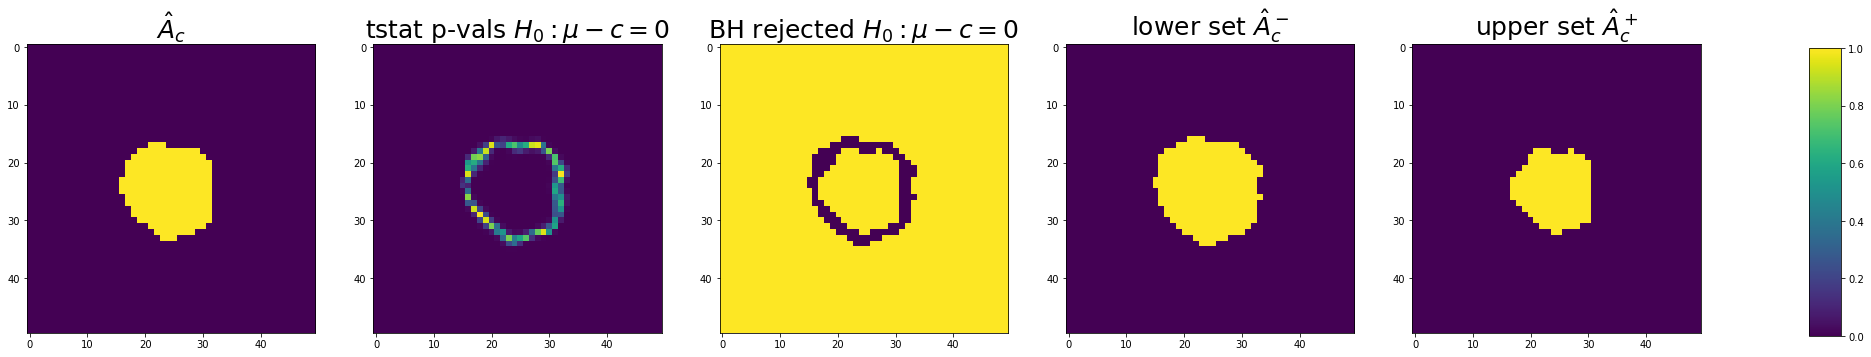

In [7]:
data = circular_s_smth
threshold = 2
alpha = 0.05

data_tstat = mvtstat(data - threshold)
data_dim = data.shape

nsubj = data_dim[0]
Achat = data_tstat >= 0
Achat_C = data_tstat < 0


# a two sided test
pvals = 2*(1 - scipy.stats.t.cdf(abs(data_tstat), df=nsubj - 1))
rejection_ind, _, _ = fdr_BH(pvals, alpha)
outer_set_2 = 1- Achat_C * rejection_ind
inner_set_2 = Achat*rejection_ind
  


fig, axs = plt.subplots(1, 5, figsize=(30, 20))

_min, _max = 0,1

im = axs[0].imshow(Achat)
axs[0].set_title("$\hat{A}_c$", fontsize = 25)
im = axs[1].imshow(pvals, vmin = _min, vmax = _max)
axs[1].set_title("tstat p-vals $H_0: \mu-c = 0$", fontsize = 25)
im = axs[2].imshow(rejection_ind, vmin = _min, vmax = _max)
axs[2].set_title("BH rejected $H_0: \mu-c = 0$", fontsize = 25)
im = axs[3].imshow(outer_set_2, vmin = _min, vmax = _max)
axs[3].set_title("lower set $\hat{A}_c^-$", fontsize = 25)
im = axs[ 4].imshow(inner_set_2, vmin = _min, vmax = _max)
axs[4].set_title("upper set $\hat{A}_c^+$", fontsize = 25)


cbar_ax = fig.add_axes([0.95, 0.4, 0.015, 0.2])
fig.colorbar(im, cax=cbar_ax, cmap='Greys')

plt.show()


#    outer_set = 1- Achat_C*outer_rejection_ind = Achat {Union} rejection_ind complement
#    inner_set = Achat*inner_rejection_ind

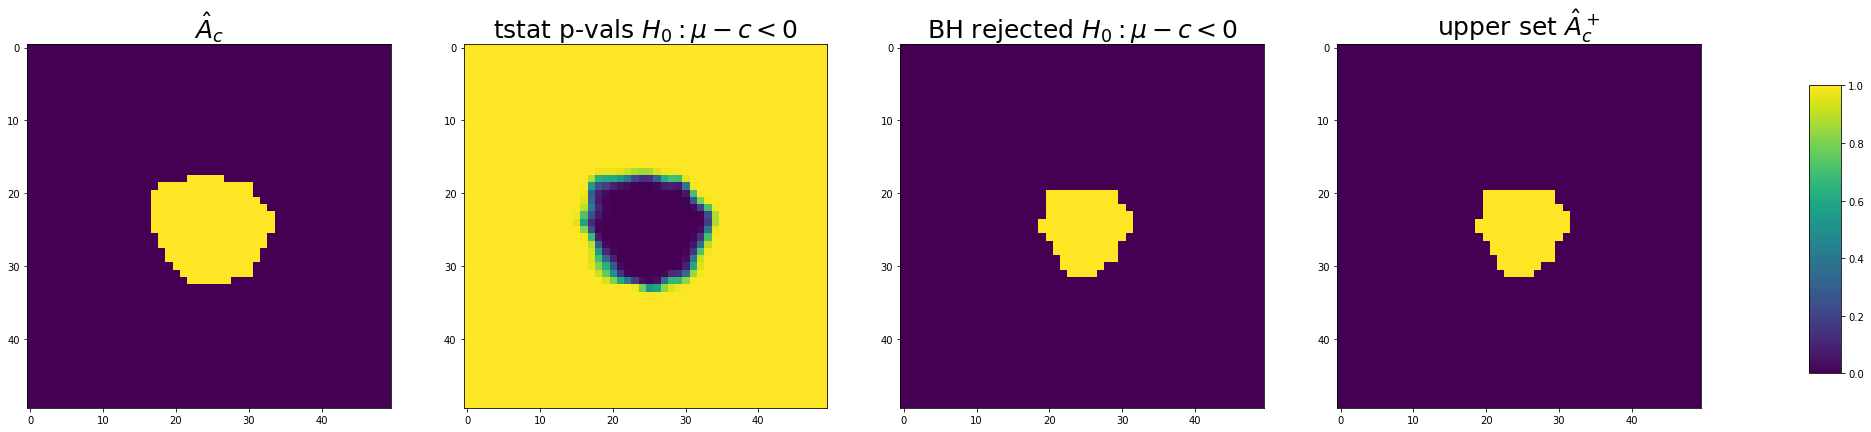

In [4]:
# one-sided for upper set (H_0: mu < c)
data = circular_s_smth
threshold = 2
alpha = 0.05

data_tstat = mvtstat(data - threshold)
data_dim = data.shape

nsubj = data_dim[0]
Achat = data_tstat >= 0
Achat_C = data_tstat < 0


pvals = (1 - scipy.stats.t.cdf(data_tstat, df=nsubj - 1))
rejection_ind, _, _ = fdr_BH(pvals, alpha)
inner_set_1 = Achat*rejection_ind
  


fig, axs = plt.subplots(1, 4, figsize=(30, 20))

_min, _max = 0,1

im = axs[0].imshow(Achat)
axs[0].set_title("$\hat{A}_c$", fontsize = 25)

im = axs[1].imshow(pvals, vmin = _min, vmax = _max)
axs[1].set_title("tstat p-vals $H_0: \mu-c < 0$", fontsize = 25)


im = axs[2].imshow(rejection_ind, vmin = _min, vmax = _max)
axs[2].set_title("BH rejected $H_0: \mu-c < 0$", fontsize = 25)

im = axs[3].imshow(inner_set_1, vmin = _min, vmax = _max)
axs[3].set_title("upper set $\hat{A}_c^+$", fontsize = 25)


cbar_ax = fig.add_axes([0.95, 0.4, 0.015, 0.2])
fig.colorbar(im, cax=cbar_ax, cmap='Greys')

plt.show()

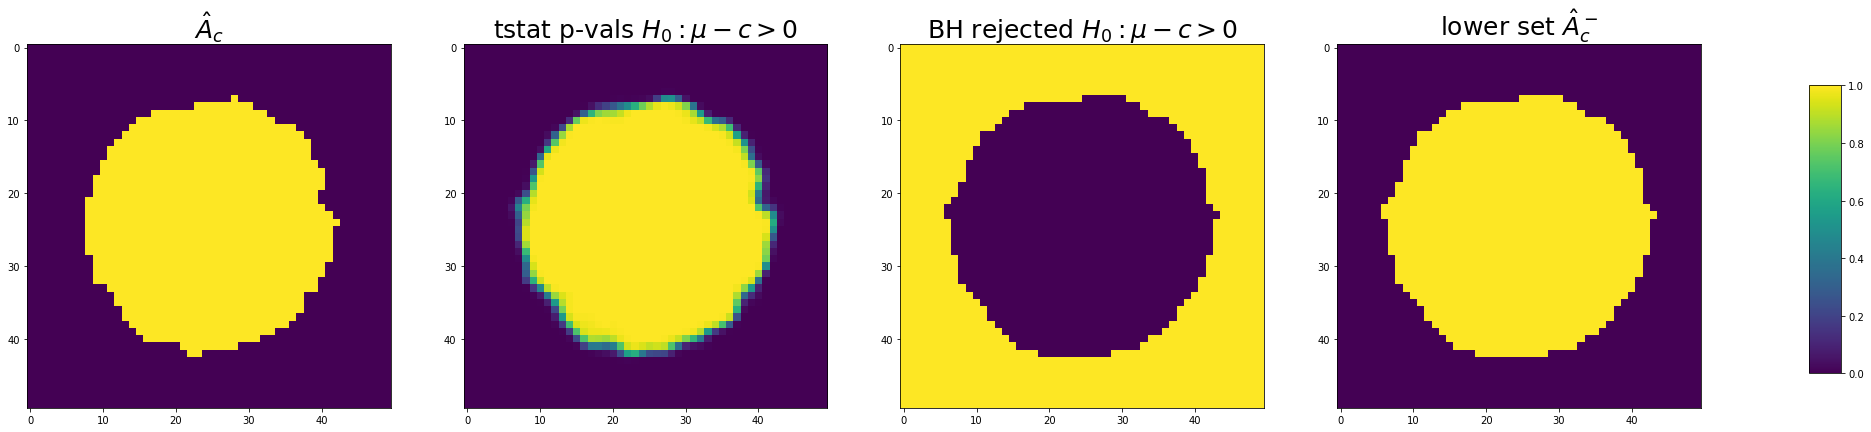

In [5]:
# one-sided for lower set (H_0: mu > c) 
data = circular_l_smth
threshold = 2
alpha = 0.05

data_tstat = mvtstat(data - threshold)
data_dim = data.shape

nsubj = data_dim[0]
Achat = data_tstat >= 0
Achat_C = data_tstat < 0

pvals = (scipy.stats.t.cdf(data_tstat, df=nsubj - 1))
rejection_ind, _, _ = fdr_BH(pvals, alpha)
outer_set_1 = (1 - Achat_C*rejection_ind) #using Ac- formula

fig, axs = plt.subplots(1, 4, figsize=(30, 20))

_min, _max = 0,1

im = axs[0].imshow(Achat)
axs[0].set_title("$\hat{A}_c$", fontsize = 25)

im = axs[1].imshow(pvals, vmin = _min, vmax = _max)
axs[1].set_title("tstat p-vals $H_0: \mu-c > 0$", fontsize = 25)


im = axs[2].imshow(rejection_ind, vmin = _min, vmax = _max)
axs[2].set_title("BH rejected $H_0: \mu-c > 0$", fontsize = 25)

im = axs[3].imshow(outer_set_1, vmin = _min, vmax = _max)
axs[3].set_title("lower set $\hat{A}_c^-$", fontsize = 25)


cbar_ax = fig.add_axes([0.95, 0.4, 0.015, 0.2])
fig.colorbar(im, cax=cbar_ax, cmap='Greys')

plt.show()

## Confidence Sets
Now we look at $\hat{A}_c^+ + \hat{A}_c^-$ + $A_c$

### BH

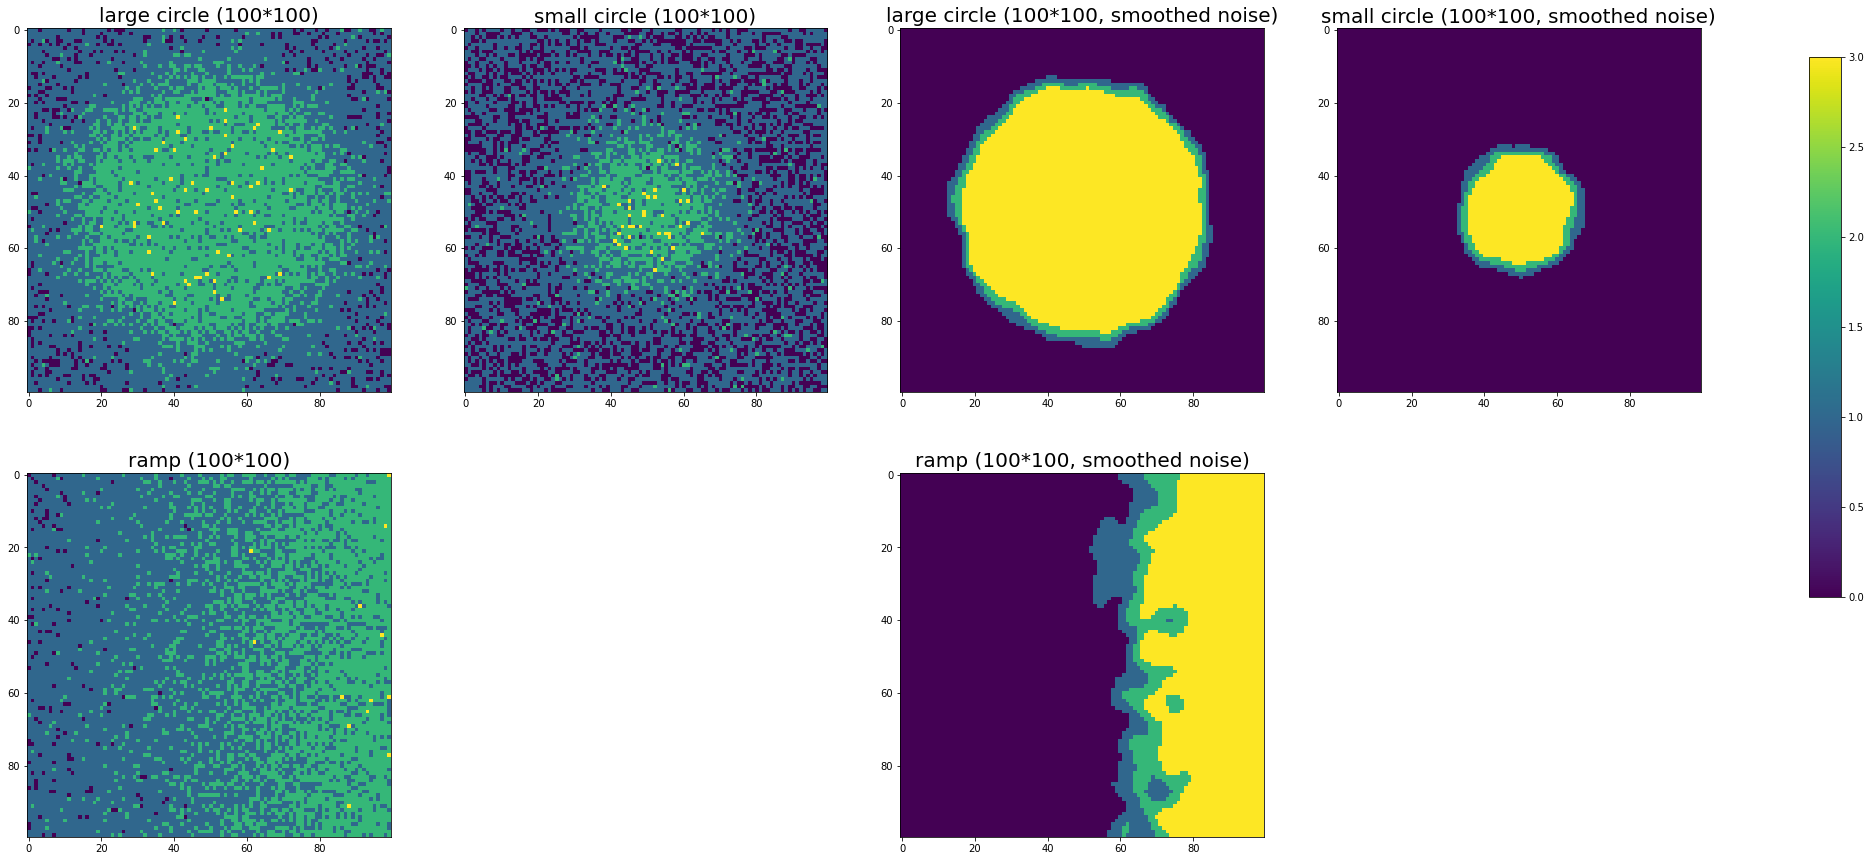

In [4]:
conf_plot_agg(c=2, std=8, tail="two", method="BH", _min=0, _max=3, fontsize=20, figsize = (30,15))

### Adaptive

*   Used k=2, $\alpha_0 = 0.05/4$, $\alpha_1 = 0.05/2$

In [8]:
conf_plot_agg(c=2, std=8, tail="two", method="adaptive", _min=0, _max=3, fontsize=20, figsize = (30,15))

NameError: ignored

# FDR Simulations

## 1) FDR: $E\frac{| \{\hat{A}_c^+ - A_c\} 𝖴 \{ A_c - \hat{A}_c^-\} |} { | \hat{A}_c^+ 𝖴  \hat{A}_c^{-c} |  }$


Sanity check: No signal image with c=0 (expecting <0.05 FDR)

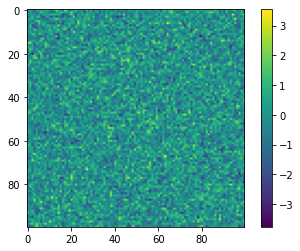

100*100 no signal ERR: 0.0


In [5]:
dim_l = (80,100,100)
no_signal = np.random.randn(*dim_l)
plt.imshow(no_signal[0,:,:])
plt.colorbar()
plt.show()

nosig_ERR1 = []
num_sim=5
for i in np.arange(num_sim):
  nosig_ERR1.append(fdr_error_check(dim=(80,100,100), c=0, method="BH", shape = 'noise', std=3, alpha=0.05, tail="two"))

print("100*100 no signal ERR:", np.mean(nosig_ERR1))


FDR 1,000 simulations

### BH

In [ ]:
BH50, BH100 = fdr_error_check_sim(sim_num=1000, method="BH", c=(0.5,2,3), c_marg=0.1, std=5, tail="two", alpha=0.05, alpha0=0.05/4, alpha1=0.05/2)
print("------------------------------------------------------------------BH FDR ERR(noise~N(0,5^2))------------------------------------------------------------------")
print("----------------------------------------------------------------------imagesize:(50*50)----------------------------------------------------------------------")
print(tabulate(BH50, headers='keys'))
print()
print("----------------------------------------------------------------------imagesize:(100*100)--------------------------------------------------------------------")
print(tabulate(BH100, headers='keys'))

### Adaptive

In [ ]:
AD50, AD100 = fdr_error_check_sim(sim_num=1000, method="adaptive", c=(0.5,2,3), c_marg=0.1, std=5, tail="two", alpha=0.05, alpha0=0.05/4, alpha1=0.05/2)
print("-------------------------------------------------------------Two-stage adaptive FDR ERR(noise~N(0,5^2))--------------------------------------------------------------")
print("----------------------------------------------------------------------imagesize:(50*50)----------------------------------------------------------------------")
print(tabulate(AD50, headers='keys'))
print()
print("----------------------------------------------------------------------imagesize:(100*100)--------------------------------------------------------------------")
print(tabulate(AD100, headers='keys'))


## 2) FDR: $E\frac{| \{\hat{A}_c^+ - A_c\} 𝖴 \{ A_c - \hat{A}_c^-\} |} { | \hat{A}_c^+ 𝖴  \hat{A}_c^{-c} |  }$



